# MAC0318 Introdução à Programação de Robôs Móveis

Vamos agora assumir que nosso **domínio é a reta real**, ou seja, que o agente navega em um ambiente e seu estado é representado pela variável aleatória $X_t$ cujo  suporte é $\mathbb{R}$. Para esse caso, nossa crença é uma **função de densidade** e portanto não podemos mais representá-la como um vetor de tamanho finito. Para tanto, vamos adotar um filtro de histograma, que retringe o suporte da função de crença a um conjunto finito de **centróides**.

In [1]:
# Vamos carregar as bibliotecas necessárias

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Filtro de histograma

O filtro de histograma representa a crença como uma somátoria de [funções de Dirac](https://en.wikipedia.org/wiki/Dirac_delta_function) centradas em pontos $x_1,\ldots,x_N$ chamados de centróides:
$$
 \text{bel}_t(x) = \sum_{c=1}^N w_{c,t} \delta(x - x_c) .
$$
Para que a função acima seja uma densidade devemos satisfazer
$$
 \int_{-\infty}^{\infty} \text{bel}_t(x) dx = 1 \Rightarrow \sum_c w_{c,t} \int_{-\infty}^{\infty} \delta(x-x_c) dx = \sum_c w_{c,t} = 1 .
$$
e
$$
 \text{bel}_t(x) \geq 0 \Rightarrow w_{c,t} \geq 0 .
$$
Na derivação acima usamos a propriedade das funções de Dirac:
$$
 \int_{-\infty}^{\infty} \delta(x-x_c) dx = 1 .
$$

Definimos as posições dos centróides especificando um intervalo $[x_\min, x_\max]$ e uma quantidade de pontos $N$. Note que nossa crença sempre atribuí probabilidade zero para qualquer estado fora desse intervalo, portanto é preciso escolher o intervalo de maneira adequada.

In [2]:
xmin, xmax = 0, 10
N = 10
centroides = np.linspace(xmin,xmax,N)

Vamos escrever uma função para representar visualmente a função de crença.

In [3]:
def show_belief(b):
    b = b.flatten()
    states = plt.bar(centroides, b)
    plt.xticks(centroides)
    plt.ylim([0, 1])
    plt.ylabel('bel(X)')
    plt.xlabel('X')
    plt.title('Crença')

Vamos supor uma crença uniforme (máxima ignorância). Note que a largura das barras são apenas para visualização; a função de crença define uma densidade não nula apenas nos centróides. A função de crença é representada pelo vetor de pesos $w_1, \ldots, w_N$.

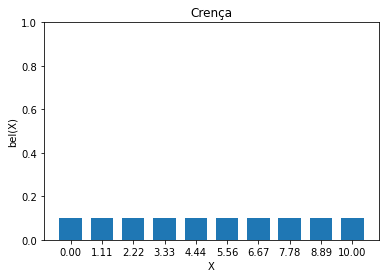

In [4]:
bel = (1/N)*np.ones(N)

show_belief(bel)

In [5]:
# Teste de consistência

bel.sum()

1.0

### Modelo de sensor

Vamos também supor que dispomos de um **sensor imperfeito** que nos fornece a posição do robô com alguma precisão. Em particular, vamos assumir que o erro do sensor é modelado por uma variável gaussiana com média 0 e variância $\sigma^2$:
$$
    p(y|X_t=x) = \mathcal{N}(x, \sigma^2) .
$$

Note que agora tanto a variável de estado quanto a variável de observação são contínuas, e portanto, suas variáveis aleatórias possuem funções de densidades associadas (ao invés de distribuições de massa de probabilidade).

In [6]:
sigma2 = 1.5

def sensor(y, x): 
    ''' Return p(y|X=x). '''
    return norm.pdf(y, loc=x, scale=np.sqrt(sigma2))

Por exemplo, quando estamos em $X_t = 2$, nosso sensor retorna valores de acordo com a função de densidade abaixo

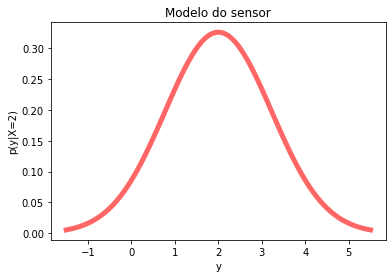

In [7]:
yspace = np.linspace(-1.5, 5.5, 100)
plt.plot(yspace, [sensor(y,2) for y in yspace], 'r-', lw=5, alpha=0.6);
plt.ylabel('p(y|X=2)');
plt.xlabel('y');
plt.title('Modelo do sensor');

### Correção

A atualização da crença para uma observação $Y_t=y$ é dada por:

$$
\begin{align}
    \text{bel}_{t+1}(x) &= p(x|y) \\
    & = \frac{p(y | x)\text{bel}_t(x)}{p(y)} \\
    & = \eta p(y|x) \sum_{c=1}^N w_{c,t}  \delta(x-x_c) ,
\end{align}
$$
onde $\eta$ é uma constante de normalização. 
Pela definição da função de Dirac, a equação acima é nula para qualquer estado diferente de um centróide, $x \neq x_c$. E para um centróide $x=x_c$, a equação se torna
$$
\text{bel}_{t}(x_c) = \eta p(y|x_c) w_{c,t} .
$$
A nova crença portanto tem a mesma forma anterior:
$$
    \text{bel}_{t+1}(x) = \sum_{c=1}^N w_{c,t+1}  \delta(x-x_c) ,
$$
com os novos pesos calculados por
$$
w_{c,t+1} = \eta p(y|x_c) w_{c,t}
$$
e
$$
 \eta = \sum_{c=1}^N  p(y|x) w_{c,t} .
$$
Note que do ponto de vista computacional, a atualização é similar ao filtro bayesiano discreto: computamos o produto ponto-a-ponto da crença antiga pelo modelo de sensor em cada centróide e renormalizamos o vetor resultante. 

In [8]:
def correct(b, y):
    ''' Update belief vector b given observation y -- Calls sensor model sensor(y) = p(Y=y|x).  '''
    tilde_bel = np.array([sensor(y,x) for x in centroides]).T # p(Y=y|X=x)
    tilde_bel *= b # bel(X) * p(y|X)
    # normaliza e atualiza vetor de crença
    b[:] = tilde_bel/np.sum(tilde_bel) 

Vamos testar o algoritmo supondo uma observação de $y=0.9$

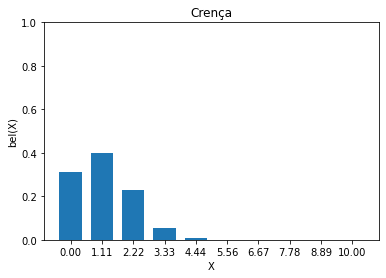

In [9]:
# observa Y=0.9

correct(bel, 0.9)

show_belief(bel) 

Note como a nova crença se concentra ao redor do valor medido, reflentindo uma redução da incerteza (entropia) da estimação de estado.

### Modelo de transição

Para o modelo de transição, vamos assumir que o robô executa uma ação de se mover $u$ unidades em um intervalo $[-1,1]$, e que o robô se movimenta de acordo com o seguinte modelo:

$$
  x_{t+1} = x_t + u + k*u*\epsilon
$$

com $\epsilon$ sendo uma variável gaussiana com média 0 e variância 1. A constante $k$ regular a variância da imprecisão do movimento. A função de densidade da transição dessa forma é dada por
$$
p(x_{t+1} | x_t, u) = \mathcal{N}(x_t + u, k^2 u^2) .
$$

In [10]:
k = 1.0 # regula variância no movimento

### Predição

A etapa de atualização da crença para uma dada ação $u$ é obtida por:
$$
\begin{align}
  \text{bel}_{t+1}(x') &= \int_{-\infty}^{\infty} p(x' | X_t=x, u) \text{bel}_t(x) dx \\
  & = \int_{-\infty}^{\infty} p(x' | X_t=x, u) \sum_{c} w_{c,t} \delta(x-x_c) dx \\
  & =   \sum_{c} w_{c,t} \int_{-\infty}^{\infty} p(x' | X_t=x, u) \delta(x-x_c) dx \\
  & =  \sum_{c} w_{c,t} p(x' | X_t=x_c, u).
\end{align}
$$
Note que a equação acima atribui densidade a qualquer ponto $x'$ do espaço, violando nossa hipótese inicial (ou seja, a forma funcional do filtro não é fechada sobre a operação de predição acima). Para recuperarmos a propriedade inicial, vamos impor que
$$
\text{bel}_{t+1}(x') = \sum_{c=1}^N w_{c,t+1} \delta(x-x_c) .
$$
Igualando as duas equações temos que:
$$
w_{c',t+1} = \sum_{c=1}^N w_{c,t} p(x_{c'} | X_t=x_c, u) .
$$
Ou seja, cada novo peso é a convolução da crença anterior e da função de transição. Note que a função de transição dentro da soma acima é calculada apenas em centróides. Dessa forma, podemos representá-la por uma matriz $T$ de tamanho $N$-por-$N$ tal que $T(x_i,x_j) = p(x_i|x_j,u)$. Para garantirmos que os novos pesos $w_{c'}$ somem um, é suficiente que as colunas de $T$ somem um. Dessa forma, obtemos a mesma representação do filtro bayesiano discreto e computamos a nova crença $w_{\cdot,t+1}$ (novos pesos) como o produto matricial da matriz de transição $T$ e a crença antiga (pesos antigos) $w_{\cdot, t}$. A única diferença aqui, é que precisamos construir a matriz a partir do valor $u$, dado que $u$ é contínuo.

Tal similaridade com o filtro bayesiano discreto não é acidental. De fato, outra maneira de derivar o filtro de histograma é considerar uma discretização do espaço de estados em células nas quais a densidade é constante é possui valor proporcional ao da densidade no centróide. Nesse caso, os pesos $w_c$ são interpretados como a probabilidade do estado pertencer à região $c$, e as integrais são substituídas por somas como no filtro bayesiano discreto.

In [11]:
T = np.zeros((N,N)) # vamos criar uma matriz global para poupar recursos

def compute_transition_matrix(u):
    ''' Update transition matrix representing T[i,j] = p(X[t+1] = xi | X[t] = xj, U = u). '''
    for j in range(N):
        T[:,j] = norm.pdf(centroides, loc=centroides[j]+u, scale=k*u)
        T[:,j] /= T[:,j].sum()

In [12]:
def predict(b, u):
    ''' Update belief given action u. '''
    # First we update the transition matrix with the given control value
    compute_transition_matrix(u)
    # Now we update the belief weights
    b[:] = T @ b

Vamos testar para uma ação $u=2$

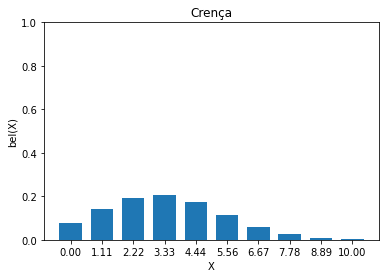

In [13]:
u = 2

predict(bel, u)

show_belief(bel)

In [14]:
# Consistência

bel.sum()

1.0000000000000002

Note que a crença sobre o estado se desloca 2 unidades para a direita e se "dilue", refeltindo um aumentando na incerteza (entropia) da estimação de estado. Se dermos um passo menor, o aumento na incerteza é menor, como especificado pelo modelo de transição.

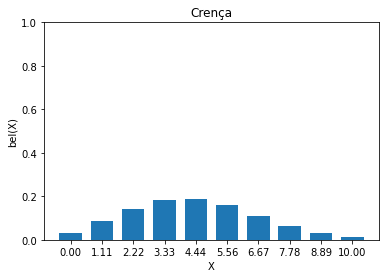

In [15]:
u = 1

predict(bel, u)

show_belief(bel)

In [16]:
bel.sum()

1.0000000000000002

Agora, se observamos $Y=3$, nossa incerteza sobre o estado diminui:

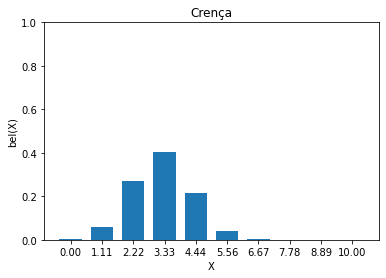

In [17]:
# observa Y=3

correct(bel, 3.0)

show_belief(bel) 

Para repassarmos a estimação de estado para um controlador, precisamos produzir um valor representativo ou estatística da distribuição. Novamente, vamos ver as duas formas mais comuns: moda e média.

In [18]:
def get_mode(b):
    ''' Extract most probable belief state. '''
    i = np.argmax(b) # distribution mode
    return centroides[i]

def get_mean(b):
    ''' Extract mean belief state value. '''
    return (centroides*b).sum()

In [19]:
x = get_mode(bel)
print('Mode state:', x)
x = get_mean(bel)
print('Mean state:', x)

Mode state: 3.3333333333333335
Mean state: 3.2331176865423212


## 💡Sua vez

Nossa derivação do filtro de histograma em duas etapas, correção e predição, é desnecessária e ineficiente. Na prática, atualizamos a crença em cada ciclo de atualização do robô, considerando a distância percorrida (velocidade vezes tempo decorrido) e obtendo uma observação.

Escreva a função `update` condensando as duas etapas em uma só. Note que só precisamos normalizar os pesos ao final. Use sua função para simular um robô tomando ações aleatórias $u \in [-1,1]$ e observações uniformes $y \in [x-1, x+1]$.

In [20]:
def update(b, y, u):
    ''' Updates belief weights b with observation y and action u. '''
    # TODO

In [22]:
x = 3 # estado inicial -- atualize estado com valor "verdadeiro" para produzir observação

u = 2*np.random.random()-1 # Para gerar valor aleatório em [-1,1]
y = x + 2*np.random.random()-1

In [23]:
x, u, y

(3, 0.36483341523251767, 2.0396251515188415)